In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import catboost as cb
from tqdm.notebook import tqdm

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import catboost as cb
from tqdm.notebook import tqdm

# from xgboost import plot_importance, plot_tree

# from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import random
import pickle

plt.style.use('fivethirtyeight')

/home/vincentpai/anaconda3/envs/wmnlab/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [44]:
!cat ~/user_state

# ex.
# Now in use: ccc
# Start time: 03/31 12:00
# Estimated end time(option): 03/31 18:00

Now in use: 
Start time:  
Estimated end time(option):  

Next one who want to use: 
Estimated start time:
Estimated end time(option): 



In [45]:
!nvidia-smi

Mon Jun 26 02:43:19 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090         On | 00000000:01:00.0 Off |                  Off |
|  0%   50C    P8               38W / 480W|      8MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Functions

In [46]:
def ts_array_create(dirname, dir_list, time_seq):
    
    columns = ['RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
               'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2']
    
    def reamin_HO_time(y_train):
        def f(L):    
            for i, e in enumerate(L):
                if e: return i+1
            return 0

        out = []
        for a2 in y_train:
            a1_out = []
            for a1 in a2:
                a1_out.append(a1.any())
      
            out.append(f(a1_out))
        return out
    
    def HO(y_train):
        out = []
        for a2 in y_train:
            if sum(a2.reshape(-1)) == 0: ho = 0
            elif sum(a2.reshape(-1)) > 0: ho = 1
            out.append(ho)
        return out

    split_time = []
    for i, f in enumerate(tqdm(dir_list)):
    
        f = os.path.join(dirname, f)
        df = pd.read_csv(f)

        # preprocess data with ffill method
        del df['Timestamp'], df['lat'], df['long'], df['gpsspeed']
        # df[columns] = df[columns].replace(0, np.nan)
        # df[columns] = df[columns].fillna(method='ffill')
        # df.dropna(inplace=True)
        
        df.replace(np.nan,0,inplace=True); df.replace('-',0,inplace=True)
        
        X = df[features]
        Y = df[target]

        Xt_list = []
        Yt_list = []

        for j in range(time_seq):
            X_t = X.shift(periods=-j)
            Xt_list.append(X_t)
    
        for j in range(time_seq,time_seq+predict_t):
            Y_t = Y.shift(periods=-(j))
            Yt_list.append(Y_t)

        # YY = Y.shift(periods=-(0))

        X_ts = np.array(Xt_list); X_ts = np.transpose(X_ts, (1,0,2)); X_ts = X_ts[:-(time_seq+predict_t-1),:,:]
        Y_ts = np.array(Yt_list); Y_ts = np.transpose(Y_ts, (1,0,2)); Y_ts = Y_ts[:-(time_seq+predict_t-1),:,:]
        split_time.append(len(X_ts))

        if i == 0:
            X_final = X_ts
            Y_final = Y_ts
        else:
            X_final = np.concatenate((X_final,X_ts), axis=0)
            Y_final = np.concatenate((Y_final,Y_ts), axis=0)

    split_time = [(sum(split_time[:i]), sum(split_time[:i])+x) for i, x in enumerate(split_time)]
    
    return X_final, np.array(HO(Y_final)), np.array(reamin_HO_time(Y_final)), split_time # forecast HO


In [47]:
def days_in_file(file, dates):
    
    for date in dates:
        if date in file: return True 
    return False

def train_valid_split(L, valid_size=0.2):
    
    length = len(L)
    v_num = int(length*valid_size)
    v_files = random.sample(L, v_num)
    t_files = list(set(L) - set(v_files))
    
    return t_files, v_files

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    print(f"Random seed set as {seed}")

# Load Data

In [48]:
# Time sequence length and prediction time length
seed = 55688
time_seq = 20
predict_t = 10
valid_ratio = 0.2
task = 'classification'

In [49]:
# Setup seed
set_seed(seed)

# Get GPU
device_count = torch.cuda.device_count()
num_of_gpus = device_count

for i in range(device_count):
    print("GPU {}: {}".format(i, torch.cuda.get_device_name(i)))
    gpu_id = i

# Save best model to 
save_path = "/home/wmnlab/Documents/sheng-ru/YU/model"

# Define DataSet
dirname = "/home/wmnlab/Documents/sheng-ru/data/single"
# dirname = "/home/wmnlab/Documents/sheng-ru/data/single0.5"
dir_list = os.listdir(dirname)
dir_list = [f for f in dir_list if ( f.endswith('.csv') and (not 'sm' in f) ) ]

train_dates = ['03-26', '04-01']
test_dates = ['04-10']
    
# train_dir_list = [f for f in dir_list if ( f.endswith('.csv') and ('All' in f) and days_in_file(f, train_dates) )]
# test_dir_list = [f for f in dir_list if ( f.endswith('.csv') and ('All' in f) and days_in_file(f, test_dates) )]

train_dir_list, test_dir_list = train_valid_split(dir_list, valid_ratio)
train_dir_list += [f for f in os.listdir(dirname) if 'sm' in f]

# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
#         'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2' ]
features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2']

num_of_features = len(features)

# target = ['LTE_HO', 'MN_HO'] # For eNB HO.
# target = ['eNB_to_ENDC'] # Setup gNB
target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
# target = ['RLF'] # For RLF
# target = ['SCG_RLF'] # For scg failure
# target = ['dl-loss'] # For DL loss
# target = ['ul-loss'] # For UL loss

# Data
print('Loading training data...')
X_train, y_train1, y_train2, split_time_train = ts_array_create(dirname, train_dir_list, time_seq)
X_train_2d = X_train.reshape(-1, time_seq*num_of_features)
cond = y_train2 > 0
X_train_fore = X_train_2d[cond]
y_train2_fore = y_train2[cond]


print('Loading testing data...')
X_test, y_test1, y_test2, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
X_test_2d = X_test.reshape(-1, time_seq*num_of_features)
cond = y_test2 > 0
X_test_fore = X_test_2d[cond]
y_test2_fore = y_test2[cond]


Random seed set as 55688
GPU 0: NVIDIA GeForce RTX 4090
Loading training data...


  0%|          | 0/148 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/29 [00:00<?, ?it/s]

# Train

In [50]:
model = cb.CatBoostClassifier(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,
                              colsample_bylevel=0.5, scale_pos_weight=1,
                              loss_function='Logloss', eval_metric = 'F1', early_stopping_rounds=10, random_seed=seed) 

In [51]:
model.fit(X_train_2d, y_train1, eval_set=(X_test_2d, y_test1), verbose=False)
# 選擇最佳迭代次數
best_iteration = model.best_iteration_

# 使用最佳迭代次數重新訓練模型
model = cb.CatBoostClassifier(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,
                              colsample_bylevel=0.8, scale_pos_weight=1,
                              loss_function='Logloss', eval_metric = 'F1', early_stopping_rounds=10, random_seed=seed)
model.fit(X_train_2d, y_train1, eval_set=(X_test_2d, y_test1), verbose=False)

In [52]:
preds = model.predict_proba(X_test_2d)[:, 1]

th: 0.2; Acc: 77.13081280463707; precision: 0.6; recall:0.97; f1:0.74
th: 0.3; Acc: 82.2553023317086; precision: 0.67; recall:0.92; f1:0.78
th: 0.4; Acc: 84.98221578184693; precision: 0.74; recall:0.85; f1:0.79
th: 0.5; Acc: 85.64089052825715; precision: 0.8; recall:0.76; f1:0.78
th: 0.6; Acc: 84.31036754050851; precision: 0.85; recall:0.65; f1:0.74
th: 0.7; Acc: 81.12238176788303; precision: 0.89; recall:0.5; f1:0.64
th: 0.8; Acc: 75.87933078645764; precision: 0.92; recall:0.31; f1:0.46


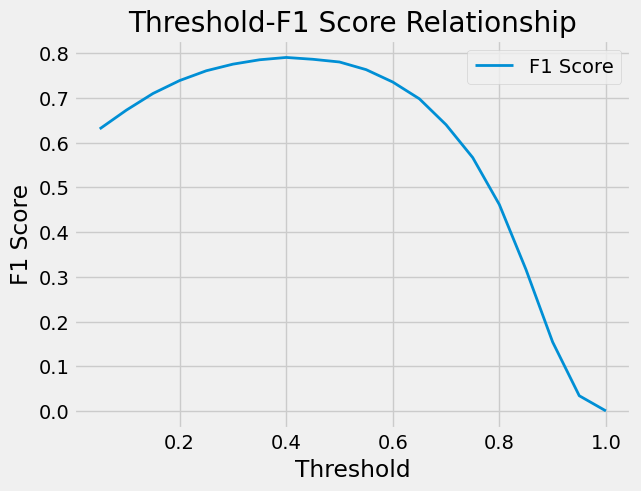

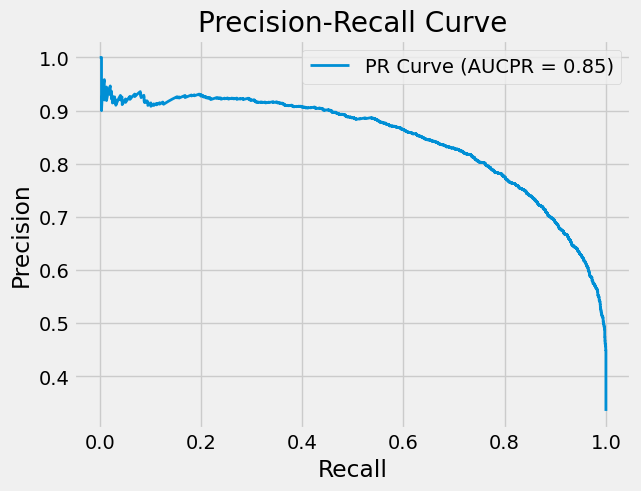

ROC Auc is 0.9283691024889289.


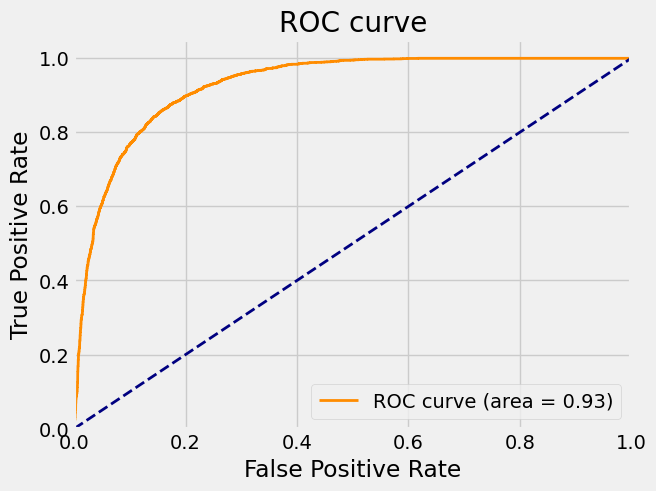

In [53]:
# plot all data point on a plot
ths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]

if task == 'forecast':
    rmse = round(np.sqrt(np.mean((preds-y_test1)**2)), 2)
    mae = np.mean(np.abs(preds-np.array(y_test1)))
    print(f'RMSE is {rmse}. MAE is {mae}')
elif task == 'classification':
    # PR and AUCPR
    precision, recall, thresholds = precision_recall_curve(y_test1, preds)
    aucpr = auc(recall, precision)
    
    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(y_test1, preds)
    roc_auc = auc(fpr, tpr)
    
    # Manually count
    for threshold in ths:
        TP, FP, TN, FN = 0,0,0,0
        anses = np.where(preds<threshold, 0, 1)
        for ans, y in zip(anses, y_test1):
            if ans == y:
                if ans == 1: TP += 1
                elif ans == 0: TN +=1
            elif ans != y:
                if ans == 1: FP += 1
                elif ans == 0: FN +=1
        acc=(TP+TN)/(TP+TN+FP+FN)*100
        try:
            p, r = round(TP/(TP+FP), 2), round(TP/(TP+FN), 2)
            f1 = round(2*(p*r)/(p+r), 2)
        except:
            p, r, f1 = 'DNF', 'DNF', 'DNF'
        s = f'th: {threshold}; Acc: {acc}; precision: {p}; recall:{r}; f1:{f1}'
        print(s)
    
    # 初始化閥值列表和 F1 Score 列表
    thresholds = []
    f1_scores = []

    # 循環遍歷閥值，計算 F1 Score
    for threshold in range(5, 101, 5):
        threshold /= 100
        y_pred_threshold = [1 if pred >= threshold else 0 for pred in preds]
        f1_scores.append(f1_score(y_test1, y_pred_threshold))
        thresholds.append(threshold)

    # 繪製閥值與 F1 Score 的關係圖
    plt.figure()
    plt.plot(thresholds, f1_scores, lw=2, label='F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('Threshold-F1 Score Relationship')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(recall, precision, lw=2, label='PR Curve (AUCPR = %0.2f)' % aucpr)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()
    
    print(f'ROC Auc is {roc_auc}.')
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f'ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

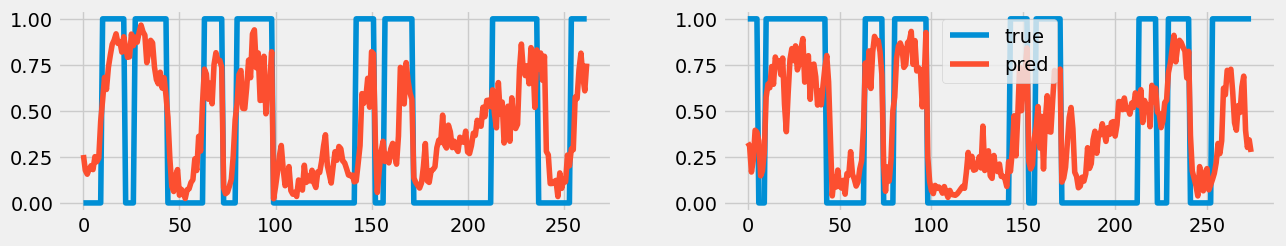

In [54]:
# visulized on many sample on validation data
sample_value = 2
# samples = random.sample(split_time_test, sample_value)
samples = [split_time_test[8], split_time_test[9]]

fig, axs = plt.subplots(1, sample_value, figsize=(14, 2.5))

# y_test
# preds

for i in range(sample_value):
    true = [y_test1[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(true, label='true')
    prediciton = [preds[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(prediciton, label='pred')

plt.legend()
plt.show()

In [42]:
A = [test_dir_list[split_time_test.index(s)] for s in samples]
A

['2023-04-17_qc02_exp2_#01_B1B7.csv', '2023-04-01_qc03_exp1_#05_B8.csv']

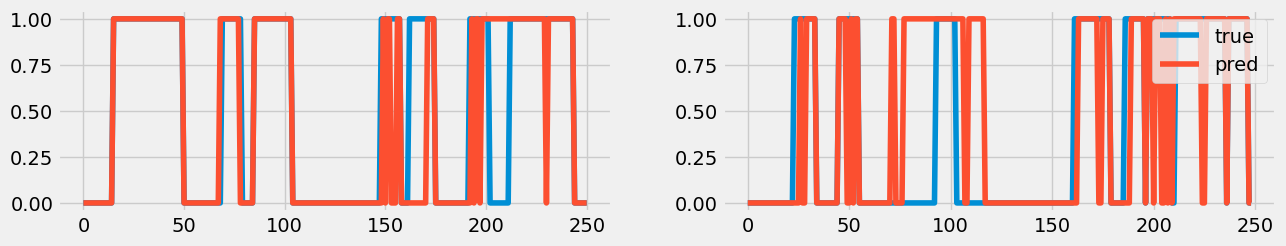

In [17]:
# Check whethet it do good on training data
sample_value = 2
samples = random.sample(split_time_train, sample_value)
preds_train = model.predict(X_train_2d)

fig, axs = plt.subplots(1, sample_value, figsize=(14, 2.5))

for i in range(sample_value):
    true = [y_train1[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(true, label='true')
    prediciton = [preds_train[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(prediciton, label='pred')

plt.legend()
plt.show()

# grid search

In [18]:
import itertools

iterations =  [100, 200, 300]
learning_rates = [0.1, 0.01, 0.001]
depths = [4, 6, 8, 10]
l2_leaf_regs = [0.1, 1, 10]
border_counts =  [5, 10, 20]
colsample_bylevels = [0.5, 0.8, 1]
scale_pos_weights = [1, 2, 5]

In [19]:
f_out = 'lte_ho_cls_cb.csv'
f_out = open(f_out, 'w')
cols_out = ['iteration','learning_rate','depth', 'l2_leaf_reg', 'border_count','colsample_bylevel','scale_pos_weight','auc','aucpr', 'p', 'r', 'f1','acc']
f_out.write(','.join(cols_out)+'\n')

for itera, lr, dep, l2_leaf, bc, cbl, spw in itertools.product(iterations, learning_rates, depths, l2_leaf_regs, border_counts, colsample_bylevels, scale_pos_weights):
    
    print(itera, lr, dep, l2_leaf, bc, cbl, spw)
    model = cb.CatBoostClassifier(iterations=itera,  learning_rate = lr, depth = dep, l2_leaf_reg = l2_leaf, 
                                  border_count = bc, colsample_bylevel= cbl,scale_pos_weight = spw, 
                              loss_function='Logloss', eval_metric = 'F1', early_stopping_rounds=10, random_seed=seed)
    
    model.fit(X_train_2d, y_train1, eval_set=(X_test_2d, y_test1), verbose=False)
    
    preds = model.predict_proba(X_test_2d)[:, 1]
    
    # AUCPR
    precision, recall, thresholds = precision_recall_curve(y_test1, preds)
    aucpr = auc(recall, precision)

    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(y_test1, preds)
    roc_auc = auc(fpr, tpr)
    threshold = 0.5

    p = precision_score(y_test1, [1 if pred > threshold else 0 for pred in preds])
    r = recall_score(y_test1, [1 if pred > threshold else 0 for pred in preds])
    f1 = f1_score(y_test1, [1 if pred > threshold else 0 for pred in preds])
    acc = accuracy_score(y_test1, [1 if pred > threshold else 0 for pred in preds])
    
    cols_out = [itera, lr, dep, l2_leaf, bc, cbl, spw, roc_auc, aucpr, p, r, f1, acc]
    cols_out = [str(n) for n in cols_out]
    f_out.write(','.join(cols_out)+'\n')
    
f_out.close()

100 0.1 4 0.1 5 0.5 1
100 0.1 4 0.1 5 0.5 2
100 0.1 4 0.1 5 0.5 5
100 0.1 4 0.1 5 0.8 1
100 0.1 4 0.1 5 0.8 2
100 0.1 4 0.1 5 0.8 5
100 0.1 4 0.1 5 1 1
100 0.1 4 0.1 5 1 2
100 0.1 4 0.1 5 1 5
100 0.1 4 0.1 10 0.5 1
100 0.1 4 0.1 10 0.5 2
100 0.1 4 0.1 10 0.5 5
100 0.1 4 0.1 10 0.8 1
100 0.1 4 0.1 10 0.8 2
100 0.1 4 0.1 10 0.8 5
100 0.1 4 0.1 10 1 1
100 0.1 4 0.1 10 1 2
100 0.1 4 0.1 10 1 5
100 0.1 4 0.1 20 0.5 1
100 0.1 4 0.1 20 0.5 2
100 0.1 4 0.1 20 0.5 5
100 0.1 4 0.1 20 0.8 1
100 0.1 4 0.1 20 0.8 2
100 0.1 4 0.1 20 0.8 5
100 0.1 4 0.1 20 1 1
100 0.1 4 0.1 20 1 2
100 0.1 4 0.1 20 1 5
100 0.1 4 1 5 0.5 1
100 0.1 4 1 5 0.5 2
100 0.1 4 1 5 0.5 5
100 0.1 4 1 5 0.8 1
100 0.1 4 1 5 0.8 2
100 0.1 4 1 5 0.8 5
100 0.1 4 1 5 1 1
100 0.1 4 1 5 1 2
100 0.1 4 1 5 1 5
100 0.1 4 1 10 0.5 1
100 0.1 4 1 10 0.5 2
100 0.1 4 1 10 0.5 5
100 0.1 4 1 10 0.8 1
100 0.1 4 1 10 0.8 2
100 0.1 4 1 10 0.8 5
100 0.1 4 1 10 1 1
100 0.1 4 1 10 1 2
100 0.1 4 1 10 1 5
100 0.1 4 1 20 0.5 1
100 0.1 4 1 20 0.5 2
100 0.1

100 0.01 4 10 5 1 1
100 0.01 4 10 5 1 2
100 0.01 4 10 5 1 5
100 0.01 4 10 10 0.5 1
100 0.01 4 10 10 0.5 2
100 0.01 4 10 10 0.5 5
100 0.01 4 10 10 0.8 1
100 0.01 4 10 10 0.8 2
100 0.01 4 10 10 0.8 5
100 0.01 4 10 10 1 1
100 0.01 4 10 10 1 2
100 0.01 4 10 10 1 5
100 0.01 4 10 20 0.5 1
100 0.01 4 10 20 0.5 2
100 0.01 4 10 20 0.5 5
100 0.01 4 10 20 0.8 1
100 0.01 4 10 20 0.8 2
100 0.01 4 10 20 0.8 5
100 0.01 4 10 20 1 1
100 0.01 4 10 20 1 2
100 0.01 4 10 20 1 5
100 0.01 6 0.1 5 0.5 1
100 0.01 6 0.1 5 0.5 2
100 0.01 6 0.1 5 0.5 5
100 0.01 6 0.1 5 0.8 1
100 0.01 6 0.1 5 0.8 2
100 0.01 6 0.1 5 0.8 5
100 0.01 6 0.1 5 1 1
100 0.01 6 0.1 5 1 2
100 0.01 6 0.1 5 1 5
100 0.01 6 0.1 10 0.5 1
100 0.01 6 0.1 10 0.5 2
100 0.01 6 0.1 10 0.5 5
100 0.01 6 0.1 10 0.8 1
100 0.01 6 0.1 10 0.8 2
100 0.01 6 0.1 10 0.8 5
100 0.01 6 0.1 10 1 1
100 0.01 6 0.1 10 1 2
100 0.01 6 0.1 10 1 5
100 0.01 6 0.1 20 0.5 1
100 0.01 6 0.1 20 0.5 2
100 0.01 6 0.1 20 0.5 5
100 0.01 6 0.1 20 0.8 1
100 0.01 6 0.1 20 0.8 2
100 0.0

100 0.001 6 0.1 20 0.5 2
100 0.001 6 0.1 20 0.5 5
100 0.001 6 0.1 20 0.8 1
100 0.001 6 0.1 20 0.8 2
100 0.001 6 0.1 20 0.8 5
100 0.001 6 0.1 20 1 1
100 0.001 6 0.1 20 1 2
100 0.001 6 0.1 20 1 5
100 0.001 6 1 5 0.5 1
100 0.001 6 1 5 0.5 2
100 0.001 6 1 5 0.5 5
100 0.001 6 1 5 0.8 1
100 0.001 6 1 5 0.8 2
100 0.001 6 1 5 0.8 5
100 0.001 6 1 5 1 1
100 0.001 6 1 5 1 2
100 0.001 6 1 5 1 5
100 0.001 6 1 10 0.5 1
100 0.001 6 1 10 0.5 2
100 0.001 6 1 10 0.5 5
100 0.001 6 1 10 0.8 1
100 0.001 6 1 10 0.8 2
100 0.001 6 1 10 0.8 5
100 0.001 6 1 10 1 1
100 0.001 6 1 10 1 2
100 0.001 6 1 10 1 5
100 0.001 6 1 20 0.5 1
100 0.001 6 1 20 0.5 2
100 0.001 6 1 20 0.5 5
100 0.001 6 1 20 0.8 1
100 0.001 6 1 20 0.8 2
100 0.001 6 1 20 0.8 5
100 0.001 6 1 20 1 1
100 0.001 6 1 20 1 2
100 0.001 6 1 20 1 5
100 0.001 6 10 5 0.5 1
100 0.001 6 10 5 0.5 2
100 0.001 6 10 5 0.5 5
100 0.001 6 10 5 0.8 1
100 0.001 6 10 5 0.8 2
100 0.001 6 10 5 0.8 5
100 0.001 6 10 5 1 1
100 0.001 6 10 5 1 2
100 0.001 6 10 5 1 5
100 0.001 6

200 0.1 6 10 5 1 2
200 0.1 6 10 5 1 5
200 0.1 6 10 10 0.5 1
200 0.1 6 10 10 0.5 2
200 0.1 6 10 10 0.5 5
200 0.1 6 10 10 0.8 1
200 0.1 6 10 10 0.8 2
200 0.1 6 10 10 0.8 5
200 0.1 6 10 10 1 1
200 0.1 6 10 10 1 2
200 0.1 6 10 10 1 5
200 0.1 6 10 20 0.5 1
200 0.1 6 10 20 0.5 2
200 0.1 6 10 20 0.5 5
200 0.1 6 10 20 0.8 1
200 0.1 6 10 20 0.8 2
200 0.1 6 10 20 0.8 5
200 0.1 6 10 20 1 1
200 0.1 6 10 20 1 2
200 0.1 6 10 20 1 5
200 0.1 8 0.1 5 0.5 1
200 0.1 8 0.1 5 0.5 2
200 0.1 8 0.1 5 0.5 5
200 0.1 8 0.1 5 0.8 1
200 0.1 8 0.1 5 0.8 2
200 0.1 8 0.1 5 0.8 5
200 0.1 8 0.1 5 1 1
200 0.1 8 0.1 5 1 2
200 0.1 8 0.1 5 1 5
200 0.1 8 0.1 10 0.5 1
200 0.1 8 0.1 10 0.5 2
200 0.1 8 0.1 10 0.5 5
200 0.1 8 0.1 10 0.8 1
200 0.1 8 0.1 10 0.8 2
200 0.1 8 0.1 10 0.8 5
200 0.1 8 0.1 10 1 1
200 0.1 8 0.1 10 1 2
200 0.1 8 0.1 10 1 5
200 0.1 8 0.1 20 0.5 1
200 0.1 8 0.1 20 0.5 2
200 0.1 8 0.1 20 0.5 5
200 0.1 8 0.1 20 0.8 1
200 0.1 8 0.1 20 0.8 2
200 0.1 8 0.1 20 0.8 5
200 0.1 8 0.1 20 1 1
200 0.1 8 0.1 20 1 2
200 0

200 0.01 8 1 5 0.8 5
200 0.01 8 1 5 1 1
200 0.01 8 1 5 1 2
200 0.01 8 1 5 1 5
200 0.01 8 1 10 0.5 1
200 0.01 8 1 10 0.5 2
200 0.01 8 1 10 0.5 5
200 0.01 8 1 10 0.8 1
200 0.01 8 1 10 0.8 2
200 0.01 8 1 10 0.8 5
200 0.01 8 1 10 1 1
200 0.01 8 1 10 1 2
200 0.01 8 1 10 1 5
200 0.01 8 1 20 0.5 1
200 0.01 8 1 20 0.5 2
200 0.01 8 1 20 0.5 5
200 0.01 8 1 20 0.8 1
200 0.01 8 1 20 0.8 2
200 0.01 8 1 20 0.8 5
200 0.01 8 1 20 1 1
200 0.01 8 1 20 1 2
200 0.01 8 1 20 1 5
200 0.01 8 10 5 0.5 1
200 0.01 8 10 5 0.5 2
200 0.01 8 10 5 0.5 5
200 0.01 8 10 5 0.8 1
200 0.01 8 10 5 0.8 2
200 0.01 8 10 5 0.8 5
200 0.01 8 10 5 1 1
200 0.01 8 10 5 1 2
200 0.01 8 10 5 1 5
200 0.01 8 10 10 0.5 1
200 0.01 8 10 10 0.5 2
200 0.01 8 10 10 0.5 5
200 0.01 8 10 10 0.8 1
200 0.01 8 10 10 0.8 2
200 0.01 8 10 10 0.8 5
200 0.01 8 10 10 1 1
200 0.01 8 10 10 1 2
200 0.01 8 10 10 1 5
200 0.01 8 10 20 0.5 1
200 0.01 8 10 20 0.5 2
200 0.01 8 10 20 0.5 5
200 0.01 8 10 20 0.8 1
200 0.01 8 10 20 0.8 2
200 0.01 8 10 20 0.8 5
200 0.0

200 0.001 8 10 10 0.8 5
200 0.001 8 10 10 1 1
200 0.001 8 10 10 1 2
200 0.001 8 10 10 1 5
200 0.001 8 10 20 0.5 1
200 0.001 8 10 20 0.5 2
200 0.001 8 10 20 0.5 5
200 0.001 8 10 20 0.8 1
200 0.001 8 10 20 0.8 2
200 0.001 8 10 20 0.8 5
200 0.001 8 10 20 1 1
200 0.001 8 10 20 1 2
200 0.001 8 10 20 1 5
200 0.001 10 0.1 5 0.5 1
200 0.001 10 0.1 5 0.5 2
200 0.001 10 0.1 5 0.5 5
200 0.001 10 0.1 5 0.8 1
200 0.001 10 0.1 5 0.8 2
200 0.001 10 0.1 5 0.8 5
200 0.001 10 0.1 5 1 1
200 0.001 10 0.1 5 1 2
200 0.001 10 0.1 5 1 5
200 0.001 10 0.1 10 0.5 1
200 0.001 10 0.1 10 0.5 2
200 0.001 10 0.1 10 0.5 5
200 0.001 10 0.1 10 0.8 1
200 0.001 10 0.1 10 0.8 2
200 0.001 10 0.1 10 0.8 5
200 0.001 10 0.1 10 1 1
200 0.001 10 0.1 10 1 2
200 0.001 10 0.1 10 1 5
200 0.001 10 0.1 20 0.5 1
200 0.001 10 0.1 20 0.5 2
200 0.001 10 0.1 20 0.5 5
200 0.001 10 0.1 20 0.8 1
200 0.001 10 0.1 20 0.8 2
200 0.001 10 0.1 20 0.8 5
200 0.001 10 0.1 20 1 1
200 0.001 10 0.1 20 1 2
200 0.001 10 0.1 20 1 5
200 0.001 10 1 5 0.5 1
20

300 0.1 10 1 10 0.5 5
300 0.1 10 1 10 0.8 1
300 0.1 10 1 10 0.8 2
300 0.1 10 1 10 0.8 5
300 0.1 10 1 10 1 1
300 0.1 10 1 10 1 2
300 0.1 10 1 10 1 5
300 0.1 10 1 20 0.5 1
300 0.1 10 1 20 0.5 2
300 0.1 10 1 20 0.5 5
300 0.1 10 1 20 0.8 1
300 0.1 10 1 20 0.8 2
300 0.1 10 1 20 0.8 5
300 0.1 10 1 20 1 1
300 0.1 10 1 20 1 2
300 0.1 10 1 20 1 5
300 0.1 10 10 5 0.5 1
300 0.1 10 10 5 0.5 2
300 0.1 10 10 5 0.5 5
300 0.1 10 10 5 0.8 1
300 0.1 10 10 5 0.8 2
300 0.1 10 10 5 0.8 5
300 0.1 10 10 5 1 1
300 0.1 10 10 5 1 2
300 0.1 10 10 5 1 5
300 0.1 10 10 10 0.5 1
300 0.1 10 10 10 0.5 2
300 0.1 10 10 10 0.5 5
300 0.1 10 10 10 0.8 1
300 0.1 10 10 10 0.8 2
300 0.1 10 10 10 0.8 5
300 0.1 10 10 10 1 1
300 0.1 10 10 10 1 2
300 0.1 10 10 10 1 5
300 0.1 10 10 20 0.5 1
300 0.1 10 10 20 0.5 2
300 0.1 10 10 20 0.5 5
300 0.1 10 10 20 0.8 1
300 0.1 10 10 20 0.8 2
300 0.1 10 10 20 0.8 5
300 0.1 10 10 20 1 1
300 0.1 10 10 20 1 2
300 0.1 10 10 20 1 5
300 0.01 4 0.1 5 0.5 1
300 0.01 4 0.1 5 0.5 2
300 0.01 4 0.1 5 0.5

300 0.001 4 0.1 5 0.8 1
300 0.001 4 0.1 5 0.8 2
300 0.001 4 0.1 5 0.8 5
300 0.001 4 0.1 5 1 1
300 0.001 4 0.1 5 1 2
300 0.001 4 0.1 5 1 5
300 0.001 4 0.1 10 0.5 1
300 0.001 4 0.1 10 0.5 2
300 0.001 4 0.1 10 0.5 5
300 0.001 4 0.1 10 0.8 1
300 0.001 4 0.1 10 0.8 2
300 0.001 4 0.1 10 0.8 5
300 0.001 4 0.1 10 1 1
300 0.001 4 0.1 10 1 2
300 0.001 4 0.1 10 1 5
300 0.001 4 0.1 20 0.5 1
300 0.001 4 0.1 20 0.5 2
300 0.001 4 0.1 20 0.5 5
300 0.001 4 0.1 20 0.8 1
300 0.001 4 0.1 20 0.8 2
300 0.001 4 0.1 20 0.8 5
300 0.001 4 0.1 20 1 1
300 0.001 4 0.1 20 1 2
300 0.001 4 0.1 20 1 5
300 0.001 4 1 5 0.5 1
300 0.001 4 1 5 0.5 2
300 0.001 4 1 5 0.5 5
300 0.001 4 1 5 0.8 1
300 0.001 4 1 5 0.8 2
300 0.001 4 1 5 0.8 5
300 0.001 4 1 5 1 1
300 0.001 4 1 5 1 2
300 0.001 4 1 5 1 5
300 0.001 4 1 10 0.5 1
300 0.001 4 1 10 0.5 2
300 0.001 4 1 10 0.5 5
300 0.001 4 1 10 0.8 1
300 0.001 4 1 10 0.8 2
300 0.001 4 1 10 0.8 5
300 0.001 4 1 10 1 1
300 0.001 4 1 10 1 2
300 0.001 4 1 10 1 5
300 0.001 4 1 20 0.5 1
300 0.00

In [20]:
import pandas as pd
df = pd.read_csv('lte_ho_cls_cb.csv')
max_value = df['aucpr'].max()
max_index = df['aucpr'].idxmax()
print(df.iloc[max_index])
max_value = df['auc'].max()
max_index = df['auc'].idxmax()
print(df.iloc[max_index])


iteration            200.000000
learning_rate          0.100000
depth                 10.000000
l2_leaf_reg           10.000000
border_count          10.000000
colsample_bylevel      0.500000
scale_pos_weight       1.000000
auc                    0.932041
aucpr                  0.858161
p                      0.809035
r                      0.774067
f1                     0.791165
acc                    0.862996
Name: 1278, dtype: float64
iteration            200.000000
learning_rate          0.100000
depth                 10.000000
l2_leaf_reg           10.000000
border_count          10.000000
colsample_bylevel      1.000000
scale_pos_weight       1.000000
auc                    0.934104
aucpr                  0.856862
p                      0.817765
r                      0.770530
f1                     0.793445
acc                    0.865499
Name: 1284, dtype: float64


# Forecast

In [32]:
model = cb.CatBoostRegressor(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,colsample_bylevel=0.5,
                              loss_function='RMSE', eval_metric = 'RMSE', early_stopping_rounds=10, random_seed=seed) 

In [33]:
model.fit(X_train_fore, y_train2_fore, eval_set=(X_test_fore, y_test2_fore), verbose=False)
best_iteration = model.best_iteration_
model = cb.CatBoostRegressor(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,colsample_bylevel=0.8,
                              loss_function='RMSE', eval_metric = 'RMSE', early_stopping_rounds=10, random_seed=seed) 
model.fit(X_train_fore, y_train2_fore, eval_set=(X_test_fore, y_test2_fore), verbose=False)

In [34]:
preds = model.predict(X_test_fore)

In [35]:
rmse = mean_squared_error(y_test2_fore, preds, squared=False)
mae = mean_absolute_error(y_test2_fore, preds)
rmse, mae

(1.9109282010550401, 1.4501505570431892)